In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gzip
import dateutil
import random
import scipy
import csv

In [2]:
DATA_DIR = Path("../data")

The following code code reads real PWV measurements for 2023 made using the Low Humidity And Temperature Profiling microwave radiometer at the Paranal Observatory, which have been retrieved trough the [LHATPRO Query Form](https://archive.eso.org/wdb/wdb/asm/lhatpro_paranal/form).

The graph shows the available PWV data. It can be seen that occasional negative values are present. These have no physical meaning and are a result of errors. No discernible pattern in the data is immediately apparent.

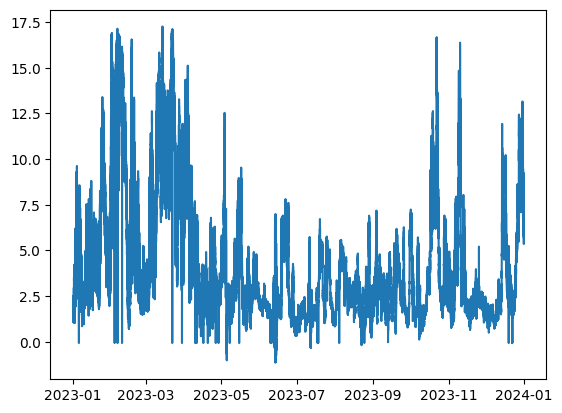

In [3]:
timestamps = []
pwv_values = []

with gzip.open(DATA_DIR / "wdb_query_eso.csv.gz", mode="rt", newline="") as fp:
	reader = csv.reader(fp)
	next(reader)
	next(reader)
	for row in reader:
		if len(row) == 3:
			p, t, pwv = row
			if pwv:
				t = dateutil.parser.parse(t)
				pwv = float(pwv)
				timestamps.append(t)
				pwv_values.append(pwv)

pwv_values = np.asarray(pwv_values)

plt.plot(timestamps, pwv_values)
plt.show()

The available PWV values follow a roughly log-normal distribution, a result consistent with previous [findings](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005JD006731). Fitting a log-normal distribution to the data yields estimates of its parameters, which will be used later.

The graph below shows the real distribution of the data and compares it with the computed log-normal model.

d:\Documents\AIExperiments\venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2357: RuntimeWarning: overflow encountered in divide
  x = (x - loc) / scale


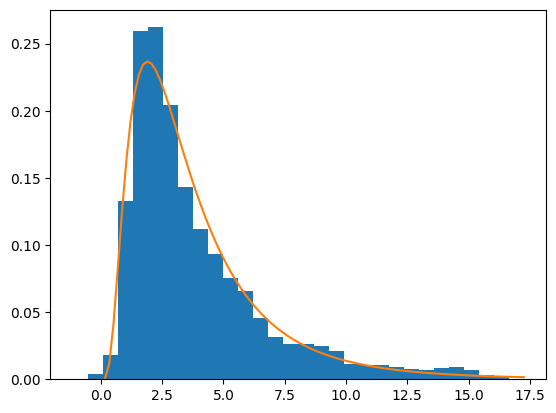

FitParams(s=0.6959519808400328, loc=0.0, scale=3.086132274709047)


In [4]:
plt.hist(pwv_values, bins=30, density=True)
#plt.show()

bounds = { "s": (0, 1), "scale": (0, 10) }
result = scipy.stats.fit(scipy.stats.lognorm, pwv_values, bounds=bounds)
params = result.params
distribution = scipy.stats.lognorm(*params)
span = np.arange(pwv_values.max(), step=pwv_values.max() / 100) + pwv_values.max() / 100
plt.plot(span, distribution.pdf(span))
plt.show()

print(params)

This stochastic process is such that $V_{k+1}=p \cdot V_k+R_{k+1}$, where $R_i$ variables are iid with distribution $\mathcal{N}(0,1)$ and $0 \le p<1$.

When $k$ is large, $\mathrm{Var}(V_k)$ converges to $\frac{1}{1-p^2}$, due to the properties of geometric series. If $V_0$ has this same variance too and is a normally-distributed random variable independent of all $R_i$ variables, then $\mathrm{Var}(V_k)$ is constant and the sampling can start at any point.

Any long segment of the generated sequence is expected to have the same mean and variance as that of any $V_k$. This is a consequence of the fact that any two elements which are sufficiently far away in the sequence are nearly independent.

Multiplying every element of the sequence by $\sqrt{1-p^2}$ results in a new sequence of variables $S_i$ with a variance and standard deviation of 1.

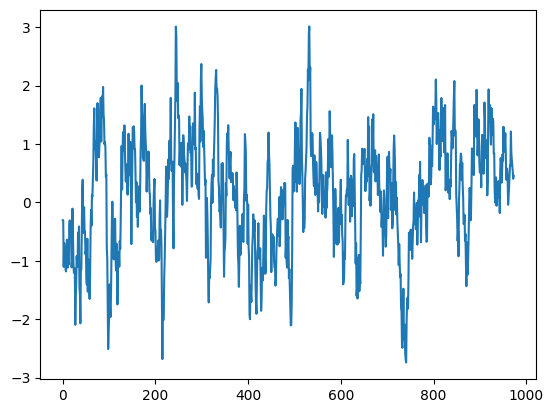

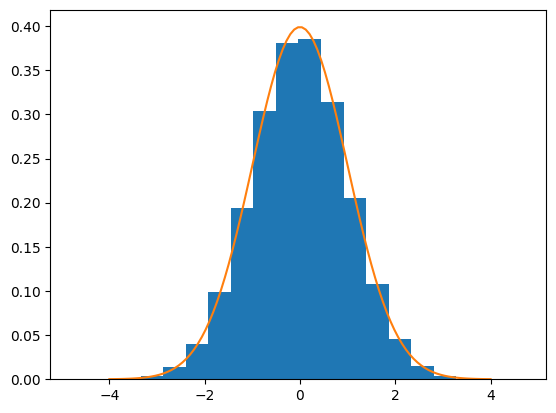

In [5]:
def random_process(size, p):
	random = np.random.normal(size=size)
	v = random[0] / np.sqrt(1 - p ** 2)
	sequence = [v]
	for r in random[1:]:
		v = v * p + r
		sequence.append(v)
	sequence = np.asarray(sequence)
	sequence *= np.sqrt(1 - p ** 2)
	return sequence

s = random_process(1000000, 0.9)

plt.plot(s[:974])
plt.show()

plt.hist(s, bins=20, density=True)
#plt.show()

x = np.linspace(-4, 4, 100)
plt.plot(x, scipy.stats.norm.pdf(x))
plt.show()

The expected value of the difference between any two values of a sequence $S$ as decribed above is 0. However, its variance depends on their distance along the sequence.

$\mathrm{Var}(S_n - S_m)$ is 0 when $d=n-m=0$ (since they are really the same element) and then it grows monotonically with $d$. When $n \gg m$, $S_m$ and $S_n$ are nearly independent, so $S_n + (-S_m)$ is effectively the sum of two independent normally distributed random variables and its variance approaches 2, drawing a horizontal asymptote.

From the graph below it can be seen that the value of $p$ can be used to control the rate at which the standard deviation of the difference between two elements in the sequence grows with their distance: the lower $p$ is, the faster elements vary in the sequence.

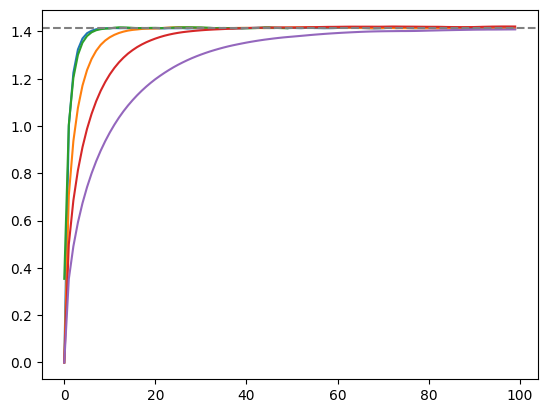

In [6]:
for exp in range(1, 5):
	sequence = random_process(1000000, 1 - 0.5 ** exp)
	stds = [0]
	for i in range(1, 100):
		diffs = sequence[i:] - sequence[:-i]
		std = np.sqrt(np.sum(diffs ** 2) / diffs.size)
		stds.append(std)
	stds = np.asarray(stds)
	plt.plot(stds)
	#plt.show()
	if exp == 2:
		stds_means = np.mean(stds.reshape(-1, 2), axis=1)
		plt.plot(stds_means)
		#plt.show()

plt.axhline(y=np.sqrt(2), linestyle="--", color="gray")

plt.show()

The following code generates a synthetic sequence of PVW values. The values across the sequence will have a lognormal distribution. The parameters of the distribution and the pace of variation across the sequence must be set to realistic values.

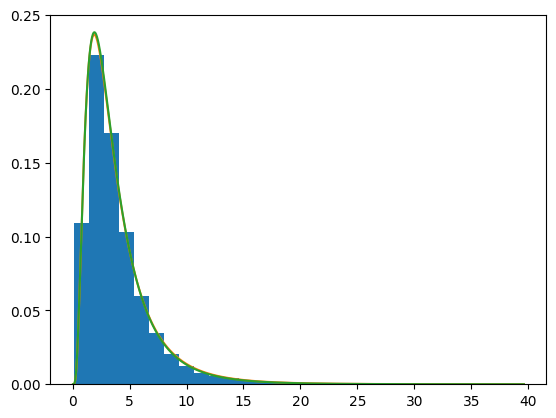

In [7]:
def random_pwv(size, dt=1, pace=1e4, s=0.69598, scale=3.0862):
	pace /= dt
	p = pace / (pace + 1)
	sequence = random_process(size, p)
	sequence *= s
	pwv = np.exp(sequence)
	pwv *= scale
	return pwv

pwv = random_pwv(10000000)

plt.hist(pwv, bins=30, density=True)
#plt.show()

distribution = scipy.stats.lognorm(0.69598, scale=3.0862)
span = np.arange(pwv.max(), step=pwv.max() / 1000) + pwv.max() / 1000
plt.plot(span, distribution.pdf(span))
#plt.show()

params = scipy.stats.lognorm.fit(pwv)
distribution = scipy.stats.lognorm(*params)
span = np.arange(pwv.max(), step=pwv.max() / 1000) + pwv.max() / 1000
plt.plot(span, distribution.pdf(span))
plt.show()

The following code shows the effect of the `pace` parameter on how fast values vary throughout the generated sequence.

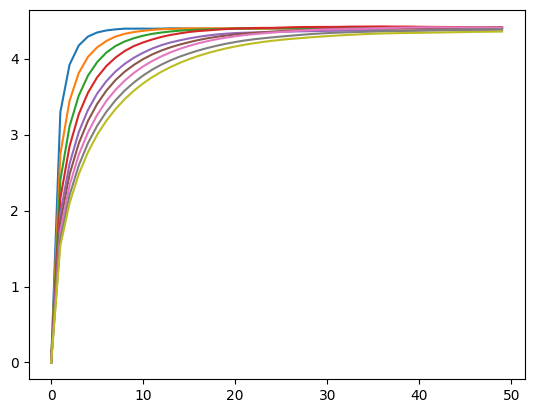

In [8]:
for pace in range(1, 10):
	pwv = random_pwv(1000000, pace=pace)
	stds = [0]
	for i in range(1, 50):
		diffs = pwv[i:] - pwv[:-i]
		std = np.sqrt(np.sum(diffs ** 2) / diffs.size)
		stds.append(std)
	stds = np.asarray(stds)
	plt.plot(stds)
	#plt.show()

plt.show()

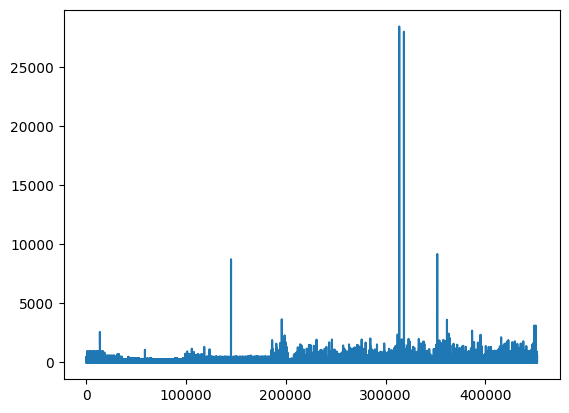

1 921 921
922 923 0
924 925 0
926 2347 0
2348 2349 0
2350 2351 0
2352 3770 0
3771 3772 0
3773 3774 0
3775 4559 0
4560 5184 0
5185 5186 0
5187 5188 0
5189 6618 0
6619 6620 0
6621 6622 0
6623 8029 0
8030 8031 0
8032 8033 0
8034 9421 0
9422 9423 0
9424 9425 0
9426 10862 0
10863 10864 0
10865 10866 0
10867 12083 0
12084 12085 0
12086 12087 0
12088 13305 0
13306 13307 0
13308 13309 0
13310 13653 0
13655 13666 0
13667 13678 0
13679 13683 0
13684 13690 0
13691 13695 0
13696 13707 0
13708 13712 0
13713 13724 0
13725 13727 0
13728 13731 0
13732 13734 0
13735 13738 0
13739 13741 0
13742 13744 0
13745 13748 0
13749 13751 0
13752 13754 0
13755 13758 0


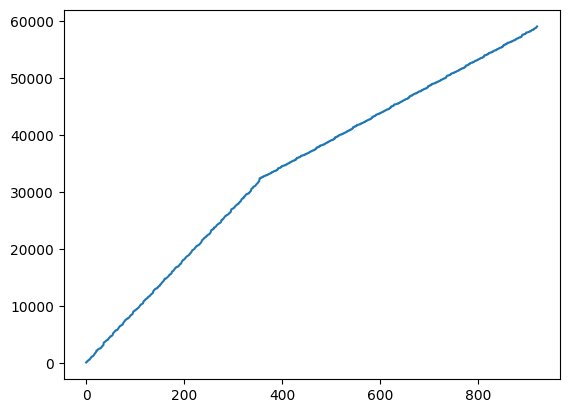

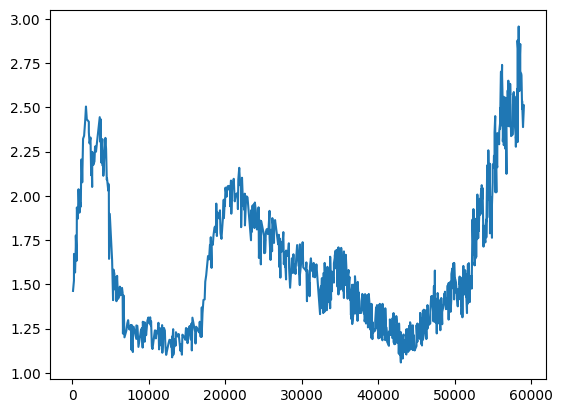

In [9]:
instants = [(t - timestamps[0]).total_seconds() for t in timestamps]
instants = np.asarray(instants)

deltas = instants[1:] - instants[:-1]
plt.plot(deltas)
plt.show()

end = 0

intervals = []

for i in range(50):
	condition = np.logical_and(deltas < 500, np.arange(deltas.size) > end)
	cell = np.argmax(deltas[end:] > 500)
	begin = np.argmax(condition)
	end = np.argmin(condition[begin + 1:]) + begin + 1
	print(begin, end, cell)
	assert condition[begin : end].all()

	if end > begin + 120:
		interval_x = instants[begin : end + 1]
		interval_y = pwv_values[begin : end + 1]

		intervals.append((interval_x, interval_y))

interval_x, interval_y = intervals[0]

plt.plot(interval_x)
plt.show()

plt.plot(interval_x, interval_y)
plt.show()

In [10]:
cond = deltas > 500
indices = np.empty(pwv_values.size, dtype=np.int32)

count = 0

indices[0] = 0

for i in range(cond.size):
	count += cond[i]
	indices[i + 1] = count

n_intervals = indices[-1]

intervals = []

for i in range(1, n_intervals):
	selected = indices == i
	if selected.sum() >= 100:
		interval_x = instants[selected]
		interval_y = pwv_values[selected]
		intervals.append((interval_x, interval_y))

for i in range(500):
	print(i, sum(i_x.size >= i for i_x, i_y in intervals))

0 378
1 378
2 378
3 378
4 378
5 378
6 378
7 378
8 378
9 378
10 378
11 378
12 378
13 378
14 378
15 378
16 378
17 378
18 378
19 378
20 378
21 378
22 378
23 378
24 378
25 378
26 378
27 378
28 378
29 378
30 378
31 378
32 378
33 378
34 378
35 378
36 378
37 378
38 378
39 378
40 378
41 378
42 378
43 378
44 378
45 378
46 378
47 378
48 378
49 378
50 378
51 378
52 378
53 378
54 378
55 378
56 378
57 378
58 378
59 378
60 378
61 378
62 378
63 378
64 378
65 378
66 378
67 378
68 378
69 378
70 378
71 378
72 378
73 378
74 378
75 378
76 378
77 378
78 378
79 378
80 378
81 378
82 378
83 378
84 378
85 378
86 378
87 378
88 378
89 378
90 378
91 378
92 378
93 378
94 378
95 378
96 378
97 378
98 378
99 378
100 378
101 376
102 375
103 374
104 374
105 374
106 374
107 373
108 372
109 372
110 372
111 372
112 371
113 370
114 370
115 369
116 369
117 369
118 367
119 366
120 366
121 366
122 366
123 364
124 364
125 364
126 364
127 363
128 362
129 361
130 361
131 360
132 359
133 358
134 357
135 357
136 356
137 356
138 35

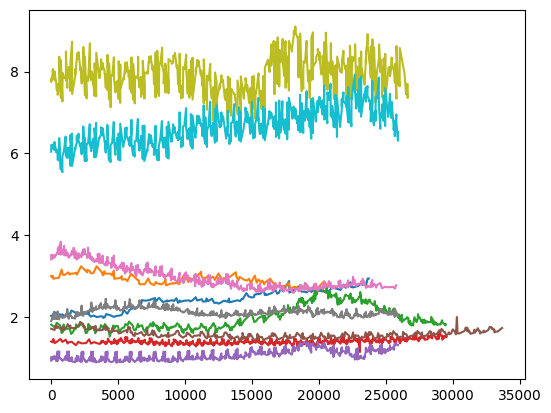

In [11]:
selected = [(i_x, i_y) for i_x, i_y in intervals if 20000 < i_x[-1] - i_x[0] < 40000]

samples = random.sample(selected, 10)

for i_x, i_y in samples:
	plt.plot(i_x - i_x[0], i_y)
	#plt.show()

plt.show()

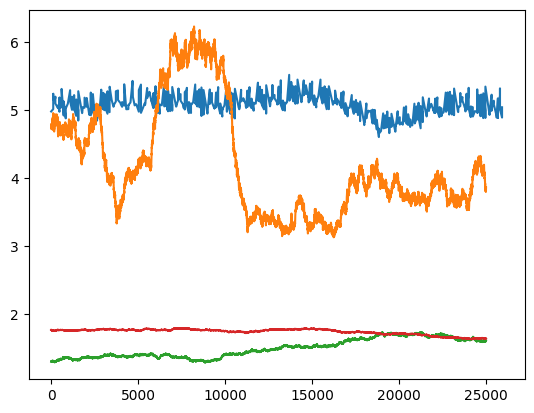

0.15266704577847906
0.8129317997454242
0.13409682312757376
0.041564651143666455


In [12]:
pwv_real = random.choice(selected)
plt.plot(pwv_real[0] - pwv_real[0][0], pwv_real[1])
#plt.show()

pwv1 = random_pwv(25000, pace=1e5)
plt.plot(pwv1)
#plt.show()

pwv2 = random_pwv(25000, pace=1e6)
plt.plot(pwv2)
#plt.show()

pwv3 = random_pwv(25000, pace=1e7)
plt.plot(pwv3)
plt.show()

print(pwv_real[1].std())
print(pwv1.std())
print(pwv2.std())
print(pwv3.std())

count = [0, 0, 0, 0]

for i in range(100):
	pwv_real = random.choice(selected)
	pwv1 = random_pwv(int(pwv_real[0][-1] - pwv_real[0][0]), pace=1e5)
	pwv2 = random_pwv(int(pwv_real[0][-1] - pwv_real[0][0]), pace=1e6)
	pwv3 = random_pwv(int(pwv_real[0][-1] - pwv_real[0][0]), pace=1e7)
	std_real = pwv_real[1].std()
	std1 = pwv1.std()
	std2 = pwv2.std()
	std3 = pwv3.std()
	if std_real < std3:
		count[3] += 1
	elif std_real < std2:
		count[2] += 1
	elif std_real < std1:
		count[1] += 1
	else:
		count[0] += 1

In [13]:
count = [0, 0, 0, 0]

for i in range(100):
	test = True
	while test:
		pwv1 = random_pwv(40000, pace=1e5)
		pwv2 = random_pwv(40000, pace=1e6)
		pwv3 = random_pwv(40000, pace=1e7)
		test = not pwv3[:20000].std() < pwv2[:20000].std() < pwv1[:20000].std()

	for i_x, i_y in selected:
		size = int(i_x[-1] - i_x[0])
		std1 = pwv1[:size].std()
		std2 = pwv2[:size].std()
		std3 = pwv3[:size].std()
		std_real = i_y.std()
		if std_real < std3:
			count[3] += 1
		elif std_real < std2:
			count[2] += 1
		elif std_real < std1:
			count[1] += 1
		else:
			count[0] += 1

In [14]:
count = [0, 0]

for i in range(100):
	test = True
	while test:
		pwv1 = random_pwv(40000, pace=6e5)
		test = False #not pwv3[:20000].std() < pwv2[:20000].std() < pwv1[:20000].std()

	for i_x, i_y in selected:
		size = int(i_x[-1] - i_x[0])
		std1 = pwv1[:size].std()
		std_real = i_y.std()
		if std_real < std1:
			count[1] += 1
		else:
			count[0] += 1

# 5e5: [162227, 167773]
# 6e5: [174765, 155235]
# 5e5: [65159, 80841]
# 6e5: [69530, 76470]
# 5e5: [67088, 77912]
# 6e5: [72194, 72806]

The following code exemplifies the generation of PWV sequences with a duration of 5 hours represented trough 59 samples.

From the graph below it can be seen that sequences with higher values also generally display more variation. The same applies to real sequences shown previously.

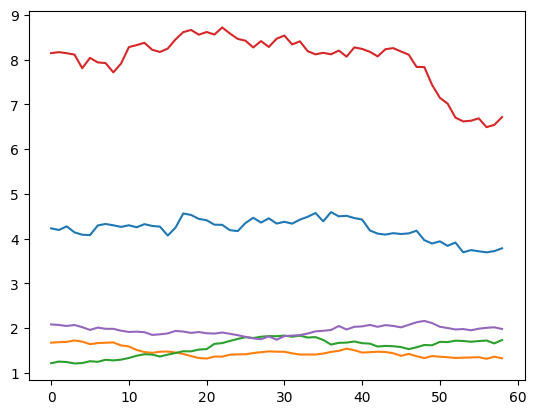

In [26]:
timespan = 5 * 60 * 60
size = 59

for i in range(5):
	pwv = random_pwv(size, dt=timespan / size, pace=6e5)
	plt.plot(pwv)
	#plt.show()

plt.show()